# Machine Learning Model
Matheus Miranda Brandão

## Imports

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Importar os dados.

In [239]:
df = pd.read_csv('../../datasets/raw/training_data.csv', sep=';')
df.head(1)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,685,Research & Development,1,3,Life Sciences,1,350,1,...,80,2,5,3,3,4,2,1,2,0


Por conversão pessoal, foi redefinido o padrão de nomeação de colunas para snake_case.

In [240]:
def camel_to_snake(col: str) -> str:
    col = ''.join([item if not item.isupper() else '_' + item for item in col])
    return col[1:].lower()

for item in df.columns:
    df.rename(columns={item: camel_to_snake(item)}, inplace=True)
del camel_to_snake
    
df.business_travel.replace(r'_', ' ', regex=True, inplace=True)

In [241]:
# A coluna Over18 só tem um valor, então não é relevante para o modelo
df.drop(columns=['over18'], inplace=True)
# As colunas EmployeeCount e StandardHours só tem um valor, então não é relevante para o modelo
df.drop(columns=['employee_count', 'standard_hours'], inplace=True)
# A coluna EmployeeNumber é apenas um identificador, então não é relevante para o modelo
df.drop(columns=['employee_number'], inplace=True)

In [242]:
df.sample(5)

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,...,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,attrition
121,50,Travel Frequently,562,Sales,8,2,Technical Degree,2,Male,50,...,1,1,18,4,3,4,3,1,3,1
715,39,Travel Frequently,505,Research & Development,2,4,Technical Degree,3,Female,64,...,4,0,20,1,3,19,6,11,8,0
1086,44,Travel Rarely,986,Research & Development,8,4,Life Sciences,1,Male,62,...,3,1,10,2,2,3,2,0,2,0
1030,38,Travel Rarely,1333,Research & Development,1,3,Technical Degree,4,Female,80,...,2,1,15,3,3,15,12,5,11,0
102,35,Non-Travel,1212,Sales,8,2,Marketing,3,Female,78,...,2,1,16,6,2,13,2,4,12,0


Mudança de do d_type dos dados para otimização do uso de memória

In [243]:
for item in df.select_dtypes('object').columns:
    df[item] = df[item].astype('category')
    
for item in df.select_dtypes('number').columns:
    ok = (df[item] == df[item].astype('int8')).unique()
    if len(ok) == 1:
        df[item] = df[item].astype('int8')
    else:
        df[item] = df[item].astype('int16')

Algumas colunas possuem ordem ou são binárias, portanto, serão tratadas com o LabelEncoder.

```python
'business_travel'
'gender'
'over_time'
```

In [244]:
for item in ['business_travel', 'gender', 'over_time']:
    df[item] = LabelEncoder().fit_transform(df[item])

Um problema foi identificado nesse dataset. A coluna attrution(target) possui um desbalanceamento muito grande, o que pode causar um viés no modelo. Para resolver esse problema, será utilizada uma técnica para balancear os dados.

In [245]:
df.attrition.value_counts(normalize=True)

attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64

## Balanceamento do dataset

Para o balanceamento do dataset foi utilizada duas técnicas em conjunto:
- Random Under-Sampling with Replacement (RUS)
- Random Over-Sampling with Replacement (ROS)

A ideia é reduzir o número de exemplos da classe majoritária e aumentar o número de exemplos da classe minoritária de forma aleatória, para que as classes fiquem mais equilibradas.

Ao final temos uma distribuição de aproximadamente 60/40.

In [246]:
def balance_dataset(df: pd.DataFrame, target: str, percentual=.45) -> pd.DataFrame:
    df_balanced = df.copy()
    while True:
        majority, minority = df_balanced[target].value_counts(normalize=True).index.to_list()
        
        if np.random.randint(2):
            idx = df_balanced[df_balanced[target] == majority].sample(1).index
            df_balanced.drop(index=idx, inplace=True)
            df_balanced.reset_index(drop=True, inplace=True)
        else:
            idx = df_balanced[df_balanced[target] == minority].sample(1).index
            df_balanced = pd.concat([df_balanced, df_balanced.iloc[idx, :]], ignore_index=True)
        
        if percentual-.05 < df_balanced[target].value_counts(normalize=True).values[1] <= percentual+.05:
            break
        
    return df_balanced

Para reprodução posterior dos experimentos foi salvo o dataset balanceado em um arquivo pkl.

In [247]:
# df_balanced = balance_dataset(df, 'attrition')
df_balanced = pd.read_pickle('../../datasets/processed/balanced_dataset.pkl')

## Preparação dos dados e Experimentos iniciais

Separação do X e y.

In [248]:
features = df_balanced.drop(columns=['attrition'])
target = df_balanced.attrition

Para uso do Pipeline e ColumnTransformer, foi separada as colunas por tipo de dado.

In [249]:
categorical = features.select_dtypes(include='category').columns.to_list()
numerical = features.select_dtypes(include='number').columns.to_list()

Criação do Pipeline para transformação dos dados.

In [250]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ]
)

Separação dos dados em treino e teste, utilizando o preceito de amostragem estratificada.

In [251]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [252]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

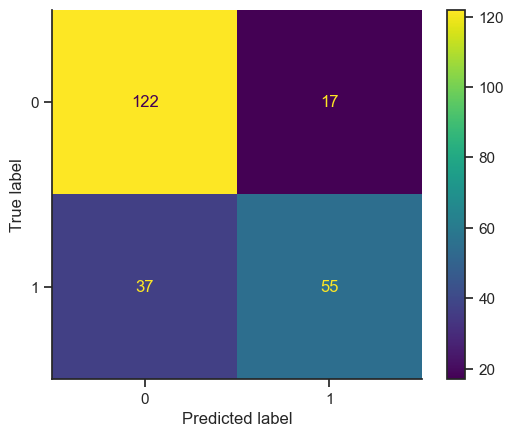

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       553
           1       0.76      0.70      0.73       370

    accuracy                           0.79       923
   macro avg       0.79      0.78      0.78       923
weighted avg       0.79      0.79      0.79       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       139
           1       0.76      0.60      0.67        92

    accuracy                           0.77       231
   macro avg       0.77      0.74      0.74       231
weighted avg       0.77      0.77      0.76       231



In [253]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [254]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

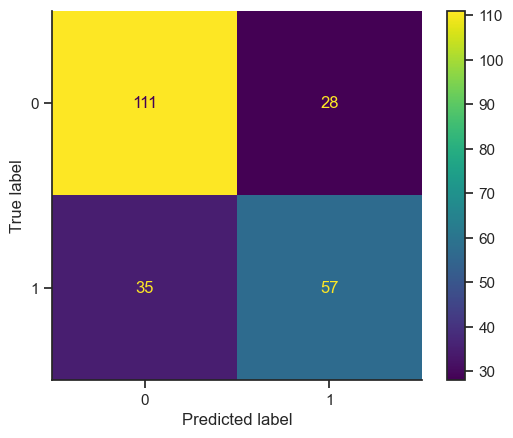

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       553
           1       0.81      0.77      0.79       370

    accuracy                           0.84       923
   macro avg       0.83      0.82      0.83       923
weighted avg       0.83      0.84      0.83       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       139
           1       0.67      0.62      0.64        92

    accuracy                           0.73       231
   macro avg       0.72      0.71      0.71       231
weighted avg       0.72      0.73      0.73       231



In [255]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [256]:
model = Pipeline(
    steps = [
        (
            'preprocessor', 
            ColumnTransformer(
                transformers=[('cat', cat_transformer, categorical)]
            )
        ),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

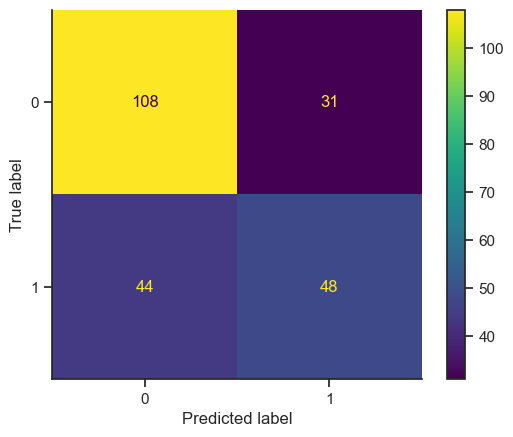

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       553
           1       0.67      0.63      0.65       370

    accuracy                           0.73       923
   macro avg       0.72      0.71      0.71       923
weighted avg       0.72      0.73      0.73       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       139
           1       0.61      0.52      0.56        92

    accuracy                           0.68       231
   macro avg       0.66      0.65      0.65       231
weighted avg       0.67      0.68      0.67       231



In [257]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Feature Selection

In [258]:
def learning_curve_of_feature(features: pd.DataFrame, target: pd.Series, var: list, model) -> tuple:
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)
    scaler = StandardScaler()
    score = {
        'Error_train': [],
        'Error_test': []
    }
    
    higher_in_train = [0, 0]
    higher_in_test = [0, 0]
    
    for i in range(1, features.shape[1]+1):
        x_train_temp, x_test_temp = x_train[var[:i]], x_test[var[:i]]
        
        categorical = x_train_temp.select_dtypes(include='category').columns.to_list()
        x_train_temp = pd.get_dummies(x_train_temp, columns=categorical, drop_first=True)
        x_test_temp = pd.get_dummies(x_test_temp, columns=categorical, drop_first=True)
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        new_model = model
        new_model.fit(x_train_temp, y_train)
        y_pred_train = new_model.predict(x_train_temp)
        y_pred_test = new_model.predict(x_test_temp)
        
        error_train = f1_score(y_train, y_pred_train)
        error_test = f1_score(y_test, y_pred_test)
        
        if error_train > higher_in_train[0]:
            higher_in_train[0] = error_train
            higher_in_train[1] = i
        if error_test > higher_in_test[0]:
            higher_in_test[0] = error_test
            higher_in_test[1] = i
        
        score['Error_train'].append(error_train)
        score['Error_test'].append(error_test)
    
    score = pd.DataFrame(score)
    return score, higher_in_train, higher_in_test

Correlação entre o target e as variáveis (ordenadas de maneira crescente).

Variável | Correlação
--- | ---
business_travel | 0.004875
education | 0.014302
hourly_rate | 0.027314
performance_rating | 0.029702
years_since_last_promotion | 0.030815
percent_salary_hike | 0.035178
gender | 0.038926
education_field | 0.045544
department | 0.053268
monthly_rate | 0.055159
job_role | 0.057578
distance_from_home | 0.058465
relationship_satisfaction | 0.060555
training_times_last_year | 0.061844
monthly_income | 0.063097
work_life_balance | 0.068202
num_companies_worked | 0.068476
daily_rate | 0.068509
job_satisfaction | 0.092833
job_involvement | 0.116793
stock_option_level | 0.117032
years_at_company | 0.122297
environment_satisfaction | 0.123244
marital_status | 0.138290
age | 0.148860
years_in_current_role | 0.149864
years_with_curr_manager | 0.150635
total_working_years | 0.158067
job_level | 0.166499
over_time | 0.252677

In [259]:
corr_in_order_of_strongness = ['over_time', 'job_level', 'total_working_years', 'years_with_curr_manager', 'years_in_current_role', 'age', 'marital_status', 'environment_satisfaction', 'years_at_company', 'stock_option_level', 'job_involvement', 'job_satisfaction', 'daily_rate', 'num_companies_worked', 'work_life_balance', 'monthly_income', 'training_times_last_year', 'relationship_satisfaction', 'distance_from_home', 'job_role', 'monthly_rate', 'department', 'education_field', 'gender', 'percent_salary_hike', 'years_since_last_promotion', 'performance_rating', 'hourly_rate', 'education']

In [260]:
curve, higher_in_train, higher_in_test = learning_curve_of_feature(features, target, corr_in_order_of_strongness, KNeighborsClassifier())

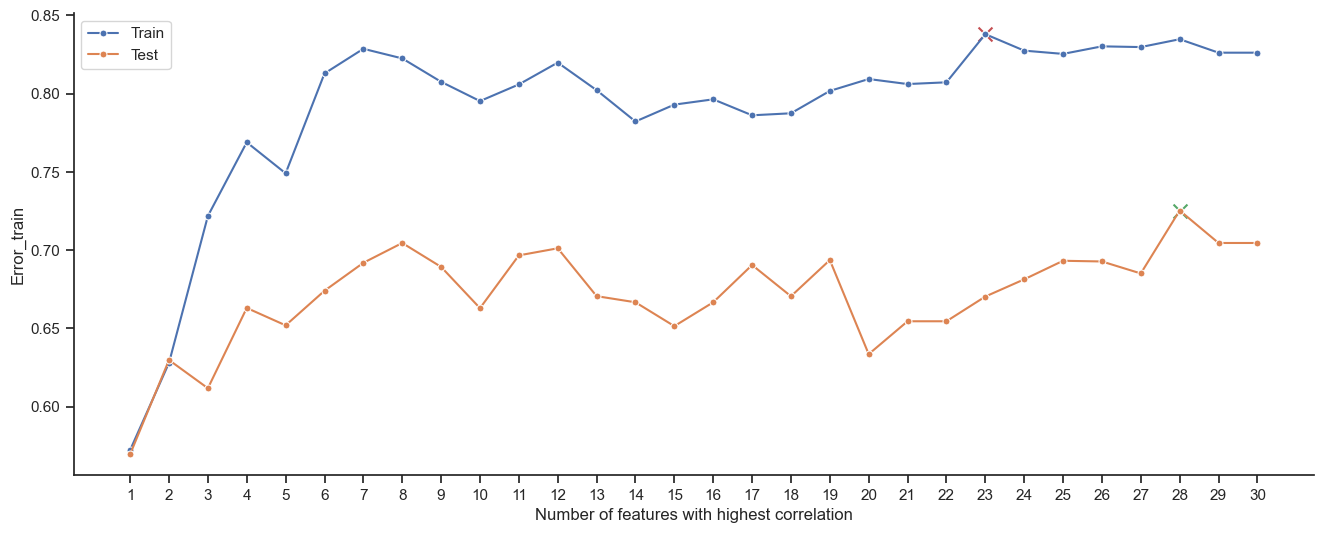

In [261]:
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(1, curve.shape[0]+1)
sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
ax.set_xticks(x)
ax.set_xlabel('Number of features with highest correlation')
ax.legend()
plt.show()

In [262]:
curve.iloc[higher_in_test[1]-1, :]

Error_train    0.834688
Error_test     0.725275
Name: 27, dtype: float64

Ao realizar o Eda, foi identificada 4 variáveis que possuem uma correlação muito alta entre si, são elas:

Variável 1 | Variável 1 | Correlação
--- | --- | ---
job_level | total_working_years | 0.79
percent_salary_hike | performance_rating | 0.77
years_at_company | years_with_curr_manager | 0.77
years_at_company | years_in_current_role | 0.75

In [263]:
def learning_curve_removing_selected_feature(features, target, var, model):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)
    scaler = StandardScaler()
    score = {
        'Feature': [],
        'Error_train': [],
        'Error_test': []
    }
    
    higher_in_train = [0, 0]
    higher_in_test = [0, 0]
    
    for i, item in enumerate(var):
        if item: x_train_temp, x_test_temp = x_train.drop(columns=item), x_test.drop(columns=item)
        else: x_train_temp, x_test_temp = x_train, x_test

        categorical = x_train_temp.select_dtypes(include='category').columns.to_list()
        
        x_train_temp = pd.get_dummies(x_train_temp, columns=categorical, drop_first=True)
        x_test_temp = pd.get_dummies(x_test_temp, columns=categorical, drop_first=True)
        
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        new_model = model
        new_model.fit(x_train_temp, y_train)
        y_pred_train = new_model.predict(x_train_temp)
        y_pred_test = new_model.predict(x_test_temp)
        
        error_train = f1_score(y_train, y_pred_train)
        error_test = f1_score(y_test, y_pred_test)
        
        if error_train > higher_in_train[0]:
            higher_in_train[0] = error_train
            higher_in_train[1] = i
        if error_test > higher_in_test[0]:
            higher_in_test[0] = error_test
            higher_in_test[1] = i
        
        score['Feature'].append(item)
        score['Error_train'].append(error_train)
        score['Error_test'].append(error_test)
    
    score = pd.DataFrame(score)
    score.Feature = score.Feature.apply(lambda x: 'All features' if x is None else x).apply(lambda x: str(x)[1:-1] if isinstance(x, list) else x).replace(r'\'', '', regex=True)
    return score, higher_in_train, higher_in_test

In [264]:
var = [None, 'years_at_company', 'total_working_years', 'performance_rating', ['years_at_company', 'total_working_years'], ['years_at_company', 'performance_rating'], ['total_working_years', 'performance_rating'], ['years_at_company', 'total_working_years', 'performance_rating']]

In [265]:
curve, higher_in_train, higher_in_test = learning_curve_removing_selected_feature(features, target, var, KNeighborsClassifier())

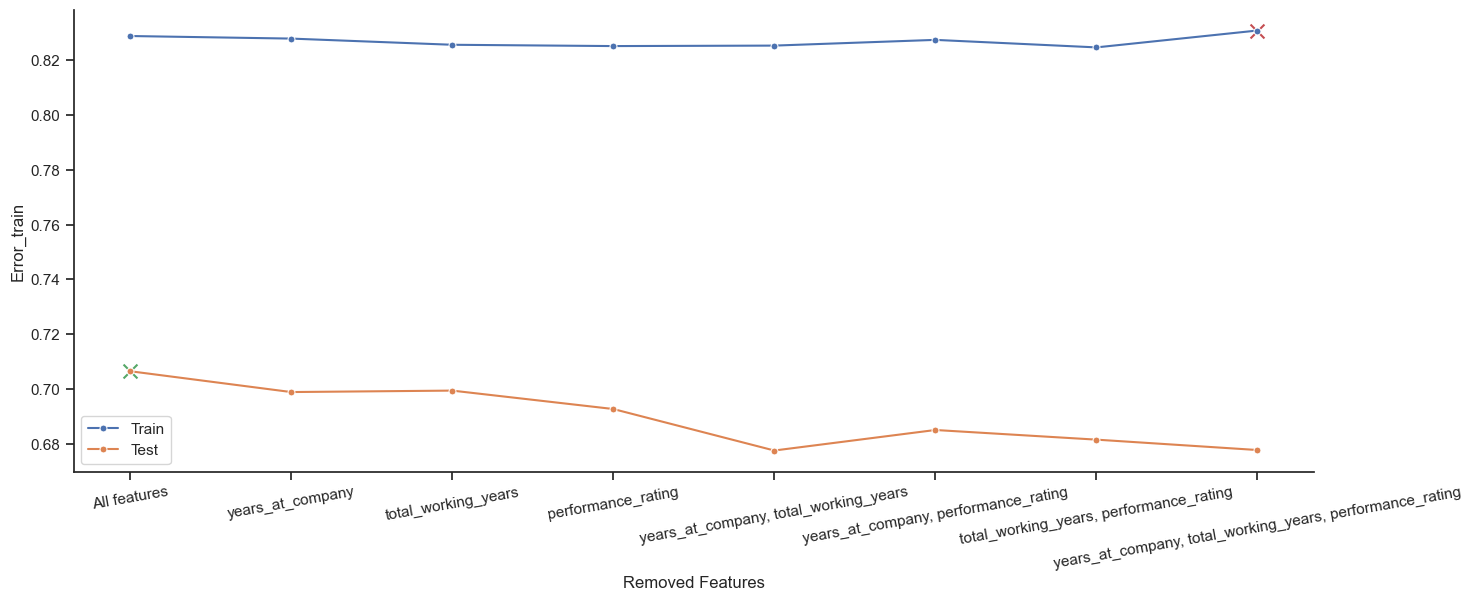

In [266]:
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(curve.shape[0])
sns.lineplot(data=curve, x='Feature', y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
sns.lineplot(data=curve, x='Feature', y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
ax.set_xticks(x)
ax.set_xlabel('Removed Features')
ax.set_xticklabels(curve.Feature, rotation=10)
ax.legend()
plt.show()

In [267]:
curve.iloc[higher_in_test[1], :]

Feature        All features
Error_train        0.828804
Error_test         0.706522
Name: 0, dtype: object

## Testes com as novas features

In [268]:
features = features[corr_in_order_of_strongness[:28]]
categorical = features.select_dtypes(include='category').columns.to_list()
numerical = features.select_dtypes(include='number').columns.to_list()

In [269]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ]
)

In [270]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [271]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

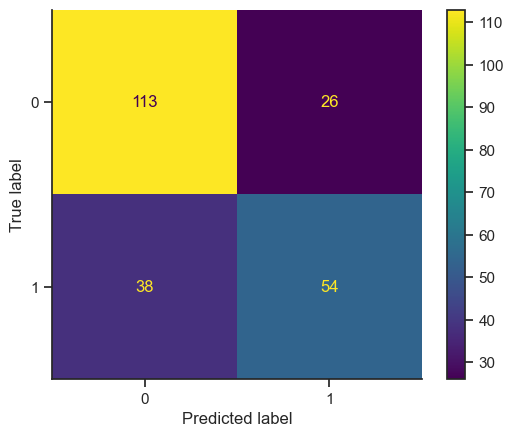

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       553
           1       0.83      0.77      0.80       370

    accuracy                           0.85       923
   macro avg       0.84      0.83      0.84       923
weighted avg       0.85      0.85      0.85       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       139
           1       0.68      0.59      0.63        92

    accuracy                           0.72       231
   macro avg       0.71      0.70      0.70       231
weighted avg       0.72      0.72      0.72       231



In [272]:

cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [273]:
features.drop(columns=['years_at_company', 'total_working_years', 'performance_rating'], inplace=True)
categorical = features.select_dtypes(include='category').columns.to_list()
numerical = features.select_dtypes(include='number').columns.to_list()

In [274]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ]
)

In [275]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [276]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

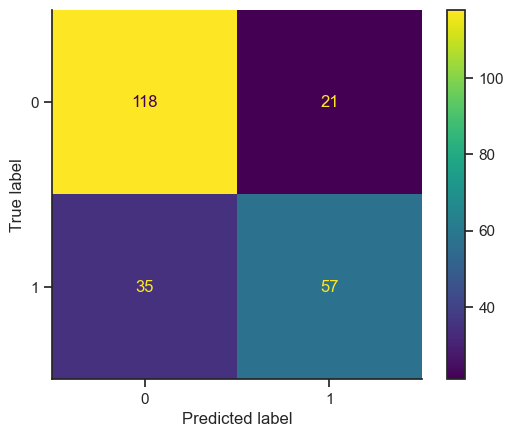

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       553
           1       0.83      0.78      0.80       370

    accuracy                           0.85       923
   macro avg       0.84      0.84      0.84       923
weighted avg       0.85      0.85      0.85       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       139
           1       0.73      0.62      0.67        92

    accuracy                           0.76       231
   macro avg       0.75      0.73      0.74       231
weighted avg       0.76      0.76      0.75       231



In [277]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Tuning dos hiperparâmetros

In [278]:
# scaler = StandardScaler()
# categorical = x_train.select_dtypes(include='category').columns.to_list()
        
# x_train_temp = pd.get_dummies(x_train, columns=categorical, drop_first=True)
# x_test_temp = pd.get_dummies(x_test, columns=categorical, drop_first=True)

# x_train_temp = scaler.fit_transform(x_train_temp)
# x_test_temp = scaler.transform(x_test_temp)

- C=0.1,
- dual=True,
- fit_intercept=False,
- penalty='l2',
- solver='liblinear',
- tol=0.0001

In [279]:
# params = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'dual': [True, False],
#     'tol': [1e-4, 1e-3, 1e-2],
#     'C': [0.1, 0.5, 1.0, 1.5, 2.0],
#     'fit_intercept': [True, False],
#     'solver': ['liblinear']
# }

# grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

- n_neighbors = 1

In [280]:
# params = {
#     'n_neighbors': np.arange(1, 100)
# }

# grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

- n_estimators = 100,
- min_samples_split = 3,
- min_samples_leaf = 1,
- max_depth = 9,
- criterion = gini

In [281]:
# params = {
#     'n_estimators': np.arange(100, 501, 100),
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': np.arange(1, 10),
#     'min_samples_split': np.arange(2, 10),
#     'min_samples_leaf': np.arange(1, 5),
# }

# grid = RandomizedSearchCV(RandomForestClassifier(random_state=42), n_iter=500, param_distributions=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

## Testes entre o modelo bruto e o modelo com feature selection e tuning

In [282]:
categorical = features.select_dtypes(include='category').columns.to_list()
numerical = features.select_dtypes(include='number').columns.to_list()

In [283]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ]
)

In [284]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [285]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=0.1, dual=True, fit_intercept=False, penalty='l2', solver='liblinear', tol=0.0001, random_state=42))
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

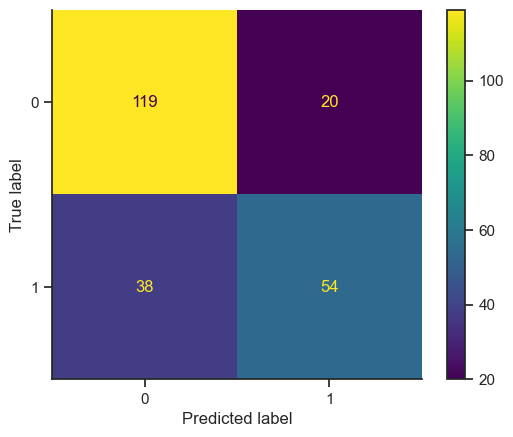

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       553
           1       0.76      0.69      0.73       370

    accuracy                           0.79       923
   macro avg       0.78      0.77      0.78       923
weighted avg       0.79      0.79      0.79       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.76      0.86      0.80       139
           1       0.73      0.59      0.65        92

    accuracy                           0.75       231
   macro avg       0.74      0.72      0.73       231
weighted avg       0.75      0.75      0.74       231



In [286]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [287]:
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=1))
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

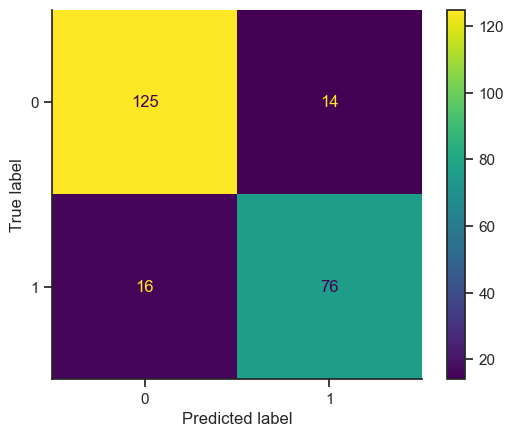

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       553
           1       1.00      1.00      1.00       370

    accuracy                           1.00       923
   macro avg       1.00      1.00      1.00       923
weighted avg       1.00      1.00      1.00       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       139
           1       0.84      0.83      0.84        92

    accuracy                           0.87       231
   macro avg       0.87      0.86      0.86       231
weighted avg       0.87      0.87      0.87       231



In [288]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [289]:
model = Pipeline(
    steps = [
        (
            'preprocessor', 
            ColumnTransformer(
                transformers=[('cat', cat_transformer, categorical)]
            )
        ),
        ('classifier', RandomForestClassifier(n_estimators=100, min_samples_split=3, min_samples_leaf=1, max_depth=9, criterion='gini', random_state=42, n_jobs=-1))
    ]
)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

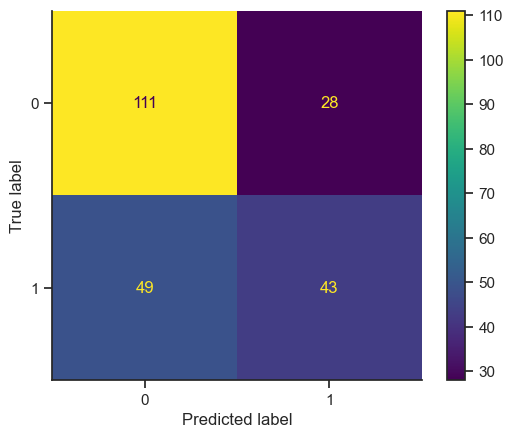

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       553
           1       0.68      0.59      0.63       370

    accuracy                           0.73       923
   macro avg       0.72      0.70      0.71       923
weighted avg       0.72      0.73      0.72       923


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       139
           1       0.61      0.47      0.53        92

    accuracy                           0.67       231
   macro avg       0.65      0.63      0.64       231
weighted avg       0.66      0.67      0.66       231



In [290]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Conclusão